In [85]:
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.model_selection import KFold
import pandas as pd
import seaborn as sns
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tqdm import tqdm
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
sns.set()
import optuna
from imblearn.over_sampling import SMOTE
import timeit

%matplotlib inline

Большая часть ноутбука повторяет бейзлайн

In [3]:
def reduce_mem_usage(df):
    NAlist = [] # Keeps track of columns that have missing values filled in. 
    for col in tqdm(df.columns):
        if df[col].dtype != object:  # Exclude strings

            # make variables for Int, max and min
            IsInt = False
            col_max_value = df[col].max()
            col_min_value = df[col].min()

            # Integer does not support NA, therefore, NA needs to be filled
            if not np.isfinite(df[col]).all(): 
                NAlist.append(col)
                df[col].fillna(col_min_value - 1, inplace=True)

            # test if column can be converted to an integer
            col_as_int = df[col].fillna(0).astype(np.int64)
            diff = (df[col] - col_as_int)
            diff = diff.sum()
            if np.abs(diff) < 0.01:
                IsInt = True

            # Make Integer/unsigned Integer datatypes
            if IsInt:
                if col_min_value >= 0:
                    if col_max_value < 255:
                        df[col] = df[col].astype(np.uint8)
                    elif col_max_value < 65535:
                        df[col] = df[col].astype(np.uint16)
                    elif col_max_value < 4294967295:
                        df[col] = df[col].astype(np.uint32)
                    else:
                        df[col] = df[col].astype(np.uint64)
                else:
                    if col_min_value > np.iinfo(np.int8).min and col_max_value < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif col_min_value > np.iinfo(np.int16).min and col_max_value < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif col_min_value > np.iinfo(np.int32).min and col_max_value < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif col_min_value > np.iinfo(np.int64).min and col_max_value < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64)    

            # Make float datatypes 32 bit
            else:
                df[col] = df[col].astype(np.float32)

    return df, NAlist

In [4]:
train_transaction = pd.read_csv('train_transaction.csv')
train_identity = pd.read_csv('train_identity.csv')
test_transaction = pd.read_csv('test_transaction.csv')
test_identity = pd.read_csv('test_identity.csv')

df_train = train_transaction.merge(train_identity, how='left', on='TransactionID')
del train_transaction, train_identity
df_train, df_train_NAlist = reduce_mem_usage(df_train)

df_test = test_transaction.merge(test_identity, how='left', on='TransactionID')
del test_transaction, test_identity
df_test, df_test_NAlist = reduce_mem_usage(df_test)

100%|████████████████████████████████████████████████████████████████████████████████| 433/433 [00:21<00:00, 19.98it/s]


Для того, чтобы улучшать качество предсказаний, можно не только менять модели и подбирать их гиперпараметры, но и модифицировать выборку. Это можно делать разными техниками - преобразования признаков, их отбор, извлечение новых и т.п. Это может помочь в силу того, что модель иногда не способна увидеть закономерности, скрытые внутри признаков, в отличие от человека, который может выделить их вручную. Подобные операции даже могут привести к появлению так называемых "magic features": их добавление к выборке может дать сильный прирост в качестве. Пример: [magic features от золотого призера одного из соревнований](https://www.kaggle.com/jturkewitz/magic-features-0-03-gain).

Посмотрим на распределение значений числового признака `'TransactionAmt'` в обучающей выборке:

D:\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


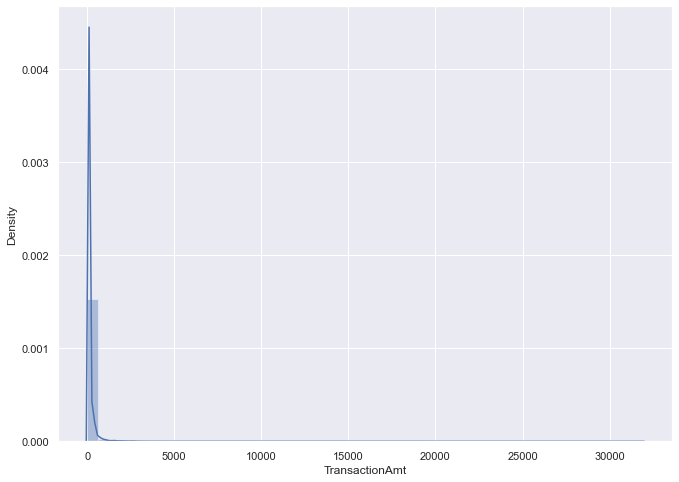

In [5]:
plt.figure(figsize=(11, 8))
sns.distplot(df_train['TransactionAmt'])
plt.show()

Как видно, распределение очень сильно смещено. Прологарифмируем признак и добавим результат в данные как новый:

In [6]:
df_train['TransactionAmt_log'] = np.log1p(df_train['TransactionAmt'])
df_test['TransactionAmt_log'] = np.log1p(df_test['TransactionAmt'])

C:\Users\DDBD~1\AppData\Local\Temp/ipykernel_9948/3186552309.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df_train['TransactionAmt_log'] = np.log1p(df_train['TransactionAmt'])
C:\Users\DDBD~1\AppData\Local\Temp/ipykernel_9948/3186552309.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df_test['TransactionAmt_log'] = np.log1p(df_test['TransactionAmt'])


D:\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


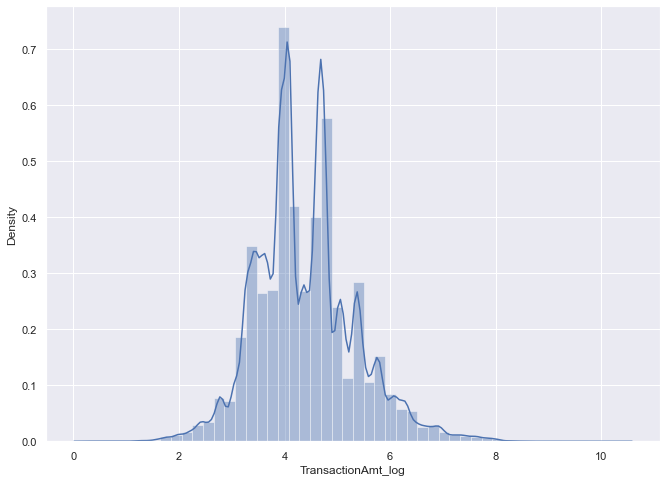

In [7]:
plt.figure(figsize=(11, 8))
sns.distplot(df_train['TransactionAmt_log'])
plt.show()

Итак, распределение мы выровняли.

Заметим, что отнюдь не все суммы транзакций (в долларах) - целочисленные:

In [8]:
df_train['TransactionAmt'].value_counts()[:15]

59.000000     20509
117.000000    19544
100.000000    16685
107.949997    15869
57.950001     15615
50.000000     14270
49.000000     10725
226.000000     7966
39.000000      7490
29.000000      7177
150.000000     6700
47.950001      6448
25.000000      6166
35.950001      5888
171.000000     5245
34.000000      5209
200.000000     5183
30.950001      5082
77.000000      4974
25.950001      4905
75.000000      4109
209.949997     4099
335.000000     3900
67.949997      3533
159.949997     3176
97.000000      3163
92.000000      2887
30.000000      2842
250.000000     2781
58.950001      2455
40.000000      2412
108.500000     2316
108.949997     2288
15.000000      2200
Name: TransactionAmt, dtype: int64

Это означает, что можно рассмотреть признак "количество центов" (вдруг мошенничество чаще совершается в случае "нецелых" транзакций?). Добавим его в данные и построим два его распределения: для мошеннических и обычных транзакций.

C:\Users\DDBD~1\AppData\Local\Temp/ipykernel_9948/2527920163.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df_train['TransactionAmt_Cents'] = np.modf(df_train['TransactionAmt'])[0] * 100
C:\Users\DDBD~1\AppData\Local\Temp/ipykernel_9948/2527920163.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df_test['TransactionAmt_Cents'] = np.modf(df_test['TransactionAmt'])[0] * 100
D:\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future ver

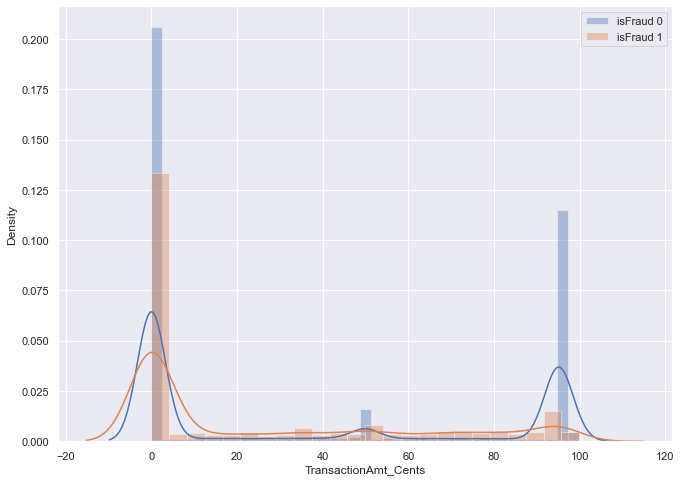

In [9]:
df_train['TransactionAmt_Cents'] = np.modf(df_train['TransactionAmt'])[0] * 100
df_test['TransactionAmt_Cents'] = np.modf(df_test['TransactionAmt'])[0] * 100

plt.figure(figsize=(11, 8))
sns.distplot(df_train[df_train['isFraud'] == 0]['TransactionAmt_Cents'], label='isFraud 0')
sns.distplot(df_train[df_train['isFraud'] == 1]['TransactionAmt_Cents'], label='isFraud 1')
plt.legend(loc='best')
plt.show()

Из имеющихся признаков можно извлекать новые. Многие признаки анонимизированы, однако есть достаточно понятные - скажем, почта или OS устройства, с которого совершалась транзакция. Извлечем новый признак - окончание почты, который может нести в себе какую-нибудь информацию - например, информацию о стране (если название домена заканчивается на `.fr`).

In [10]:
for col in ['P_emaildomain', 'R_emaildomain']:
    df_train[col + '_suffix'] = df_train[col].map(lambda x: str(x).split('.')[-1])
    df_test[col + '_suffix'] = df_test[col].map(lambda x: str(x).split('.')[-1])

df_train[['P_emaildomain', 'P_emaildomain_suffix', 'R_emaildomain', 'R_emaildomain_suffix']].tail(10)

C:\Users\DDBD~1\AppData\Local\Temp/ipykernel_9948/2111850522.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df_test[col + '_suffix'] = df_test[col].map(lambda x: str(x).split('.')[-1])


,P_emaildomain,P_emaildomain_suffix,R_emaildomain,R_emaildomain_suffix
417549,gmail.com,com,NaN,nan
417550,gmail.com,com,NaN,nan
417551,att.net,net,NaN,nan
417552,anonymous.com,com,NaN,nan
417553,yahoo.com,com,NaN,nan
417554,gmail.com,com,NaN,nan
417555,gmail.com,com,NaN,nan
417556,hotmail.com,com,hotmail.com,com
417557,gmail.com,com,NaN,nan
417558,gmail.com,com,NaN,nan


Новые признаки можно извлекать на основании сочетаний некоторых имеющихся. Например, добавим в данные признак, отвечающий за то, совпадают ли домены покупателя и получателя - вдруг это что-то даст.

In [11]:
df_train['same_emaildomain'] = (df_train['P_emaildomain'] == df_train['R_emaildomain']).astype('uint8')
df_test['same_emaildomain'] = (df_test['P_emaildomain'] == df_test['R_emaildomain']).astype('uint8')
df_train[['P_emaildomain', 'R_emaildomain', 'same_emaildomain']].tail()

C:\Users\DDBD~1\AppData\Local\Temp/ipykernel_9948/3985228817.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df_test['same_emaildomain'] = (df_test['P_emaildomain'] == df_test['R_emaildomain']).astype('uint8')


,P_emaildomain,R_emaildomain,same_emaildomain
417554,gmail.com,NaN,0
417555,gmail.com,NaN,0
417556,hotmail.com,hotmail.com,1
417557,gmail.com,NaN,0
417558,gmail.com,NaN,0


Можно комбинировать признаки - производить арифметические операции между числовыми признаками, использовать сочетания категориальных. Такие комбинации иногда позволяют породить мощные признаки. Например, если какие-то из признаков `'card1'-'card6'` и `'addr1'-'addr2'` содержат важную информацию о клиенте, то объединение некоторых из них может помочь лучше идентифицировать клиента и факт мошенничества в транзакции. Главное не переусердствовать - если признаки содержат очень много категорий, то их объединение скорее всего приведет к появлению признака с колоссальным количеством категорий, что в свою очередь может привести к ухудшению качества. Из полученного признака тогда можно извлечь какую-то информацию с помощью группировки и агрегирования, но оставлять его просто так, скорее всего, опасно. Чтобы понять, о чем речь, попробуйте объединить признаки `'card1'` и `'card2'` - это два самых важных признака для модели из бейзлайна.

В данном случае скомбинируем признаки `'card3'` и `'card5'` - они входят в топ-50 важных признаков для модели из бейзлайна.

In [12]:
df_train['card3_card5'] = df_train['card3'].astype(str) + '_' + df_train['card5'].astype(str)
df_test['card3_card5'] = df_test['card3'].astype(str) + '_' + df_test['card5'].astype(str)
df_train[['card3', 'card5', 'card3_card5']].head(10)

C:\Users\DDBD~1\AppData\Local\Temp/ipykernel_9948/800948092.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df_test['card3_card5'] = df_test['card3'].astype(str) + '_' + df_test['card5'].astype(str)


,card3,card5,card3_card5
0,150,142,150_142
1,150,102,150_102
2,150,166,150_166
3,150,117,150_117
4,150,102,150_102
5,150,226,150_226
6,150,166,150_166
7,150,226,150_226
8,150,226,150_226
9,150,224,150_224


In [13]:
for col in ['card3', 'card5', 'card3_card5']:
    print('Number of categories in train for {}: {}'.format(col, df_train[col].nunique()))

Number of categories in train for card3: 106
Number of categories in train for card5: 111
Number of categories in train for card3_card5: 553


Можно также закодировать категориальные признаки, исходя из их частоты встречаемости в выборке.

In [14]:
for col in ['card1', 'card2']:
    card_freq = df_train[col].value_counts().to_dict()
    df_train['{}_cnt'.format(col)] = df_train[col].map(card_freq)
    df_test['{}_cnt'.format(col)] = df_test[col].map(card_freq)
df_train[['card1', 'card1_cnt', 'card2', 'card2_cnt']].head(10)

C:\Users\DDBD~1\AppData\Local\Temp/ipykernel_9948/660327109.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df_test['{}_cnt'.format(col)] = df_test[col].map(card_freq)


,card1,card1_cnt,card2,card2_cnt
0,13926,29,99,6563
1,2755,526,404,2371
2,4663,778,490,26366
3,18132,2970,567,4329
4,4497,9,514,10587
5,5937,6,555,29919
6,12308,163,360,10518
7,12695,4837,490,26366
8,2803,4291,100,5372
9,17399,1293,111,31710


Наконец, можно использовать агрегирование и группировку. Например, наряду с `'card1'` и `'card2'`, одним из важнейших признаков для модели в бейзлайне является `'TransactionAmt'`. Давайте добавим в данные признаки, отвечающие за среднюю, медианную, максимальную и минимальную суммы покупок для каждой категории в `'card1'` и `'card2'`.

In [15]:
new_cols = []
for col in ['card1', 'card2']:
    for agg_type in ['mean', 'median', 'min', 'max']:
        agg_col_name = 'TransactionAmt_{}_{}'.format(col, agg_type)
        card_agg = df_train.groupby(col)['TransactionAmt'].agg([agg_type]).rename({agg_type: agg_col_name}, axis=1)
        df_train = df_train.merge(card_agg, how='left', on=col)
        df_test = df_test.merge(card_agg, how='left', on=col)
        new_cols.append(agg_col_name)
df_train[['TransactionAmt', 'card1'] + new_cols[:4] + ['card2'] + new_cols[4:]].head(10)

,TransactionAmt,card1,TransactionAmt_card1_mean,TransactionAmt_card1_median,TransactionAmt_card1_min,TransactionAmt_card1_max,card2,TransactionAmt_card2_mean,TransactionAmt_card2_median,TransactionAmt_card2_min,TransactionAmt_card2_max
0,68.5,13926,368.656219,150.000000,40.00,1343.140015,99,177.598236,78.500000,5.000,3069.250000
1,29.0,2755,243.561661,108.949997,10.00,6085.229980,404,229.298645,108.949997,5.000,6085.229980
2,59.0,4663,96.343185,59.000000,12.50,994.000000,490,132.193436,77.000000,0.424,6450.970215
3,50.0,18132,122.751434,67.949997,6.00,3190.000000,567,131.370285,77.949997,6.000,3190.000000
4,50.0,4497,105.083328,108.949997,30.00,200.000000,514,217.431381,102.000000,5.000,31937.390625
5,49.0,5937,148.250000,144.000000,49.00,317.500000,555,125.474594,68.094002,0.272,3594.949951
6,159.0,12308,107.105888,59.000000,12.50,2161.000000,360,98.937828,58.950001,5.000,3472.949951
7,422.5,12695,143.267792,85.000000,7.97,3162.949951,490,132.193436,77.000000,0.424,6450.970215
8,15.0,2803,145.065338,77.000000,5.00,3511.949951,100,172.210480,92.000000,5.000,5543.229980
9,117.0,17399,127.806297,67.949997,10.95,2775.000000,111,148.041214,87.949997,3.500,4301.950195


Напоследок отметим, что можно проводить также и отбор признаков - дело в том, что если в данных много неинформативных признаков, они могут лишь создать помехи при обучении. Способов отбора много, начиная от ручного и заканчивая специально разработанными для этого методами. В данном случае мы оставим все как есть.

После всех операций с признаками удалим столбец `'TransactionAmt'`, раз он уже есть у нас в логарифмированном виде - чтобы модель на него не отвлекалась.

In [16]:
df_train.drop('TransactionAmt', axis=1, inplace=True)
df_test.drop('TransactionAmt', axis=1, inplace=True)

Подготовим полученную выборку к обучению модели так же, как мы делали это в обычном бейзлайне.

In [17]:
for col in tqdm(df_train.columns.drop('isFraud')):
    if df_train[col].dtype == 'O':
        df_train[col] = df_train[col].fillna('unseen_category')
        df_test[col] = df_test[col].fillna('unseen_category')
        
        le = LabelEncoder()
        le.fit(list(df_train[col]) + list(df_test[col]))
        df_train[col] = le.transform(df_train[col])
        df_test[col] = le.transform(df_test[col])
        
        df_train[col] = df_train[col].astype('category')
        df_test[col] = df_test[col].astype('category')

    else:
        df_train[col] = df_train[col].fillna(-1)
        df_test[col] = df_test[col].fillna(-1)

# выделяем фолды
month_length = 3600 * 24 * 30
fold0_idx = df_train[df_train['TransactionDT'] < df_train['TransactionDT'].min() + month_length].index
fold1_idx = df_train[(df_train['TransactionDT'].min() + month_length <= df_train['TransactionDT']) & (df_train['TransactionDT'] < df_train['TransactionDT'].min() + 2 * month_length)].index
fold2_idx = df_train[(df_train['TransactionDT'].min() + 2 * month_length <= df_train['TransactionDT']) & (df_train['TransactionDT'] < df_train['TransactionDT'].min() + 3 * month_length)].index
fold3_idx = df_train[df_train['TransactionDT'].min() + 3 * month_length <= df_train['TransactionDT']].index
folds_idx = [fold0_idx, fold1_idx, fold2_idx, fold3_idx]

# выделяем идентификационный и временной признаки
df_train.drop(['TransactionID', 'TransactionDT'], axis=1, inplace=True)
df_test.drop(['TransactionID', 'TransactionDT'], axis=1, inplace=True)

100%|████████████████████████████████████████████████████████████████████████████████| 448/448 [00:15<00:00, 29.62it/s]


# Мой код
Я решил убрать признаки, у которых какое-то значение встречается в данных в >80% случаев. Позже я понял, что таргет был несбалансированы, поэтому это был неправильно шаг, но уже менять что-то не было сил честно сказать

In [54]:
a = []
b = []
for cols in tqdm(df_train.columns):
    if df_train[cols].nunique() < 100:
        if df_train[cols].dtype.name == 'category':
            for i in range(df_train[cols].nunique()):
                if df_train[cols].value_counts()[i] > 340000:
                    a.append(cols)
                    break
        else:
            for i in df_train[cols].unique():
                if df_train[cols].value_counts()[i] > 340000:
                    b.append(cols)
                    break

100%|████████████████████████████████████████████████████████████████████████████████| 447/447 [00:12<00:00, 36.70it/s]


In [19]:
a.pop(0)
df_tr = df_train.copy()
df_te = df_test.copy()
df_tr.drop(a, axis=1, inplace=True)
df_te.drop(a, axis=1, inplace=True)

Здесь я воспользовался оптимизатором optuna чтобы найти гиперпараметры модели. Сначала я оптимизировал параметры без лёрнинг рейт, потом отдельно еще оптимизировал этот параметр, то есть всего 2 оптимизации

In [70]:
def objective(trial):
    
    param_grid = {
        'objective': 'binary',
        'boosting_type': 'gbdt',
        'metric': 'auc',
        'n_jobs': -1,
        'n_estimators': 5000,
        'seed': 1,
        'early_stopping_rounds': 200,
#         "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3), сначала без нее
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.2, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.2, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100)
        
    }


    cv_scores = np.empty(4)
    
    for i in range(len(folds_idx)):
        X_train, X_val = df_tr.drop(folds_idx[i], axis=0).drop('isFraud', axis=1), df_train.iloc[folds_idx[i]].drop('isFraud', axis=1)
        y_train, y_val = df_tr.drop(folds_idx[i], axis=0)['isFraud'], df_train.iloc[folds_idx[i]]['isFraud']
        
        lgb_train = lgb.Dataset(X_train, y_train)
        lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)
        lgb_model = lgb.train(train_set = lgb_train, valid_sets=lgb_eval, verbose_eval=100, params = param_grid)
        
        y_pred = lgb_model.predict(X_val)
        score_fold = roc_auc_score(y_val, y_pred)
        cv_scores[i] = score_fold

    return np.mean(cv_scores)

In [ ]:
%%time
study = optuna.create_study(direction="maximize", study_name="LGBM Classifier_2")
study.optimize(objective, n_trials=100)
# я решил не показывать вывод данной строчки кода, т.к. она очень длинная 

In [ ]:
# полученные оптимальные гиперпараметры (находил вручную в окошке вывода)
{'lambda_l1': 1.874781296591587e-05, 'lambda_l2': 0.06378446666969453, 'num_leaves': 247, 'feature_fraction': 0.5632727860997702, 'bagging_fraction': 0.9454630708661762, 'bagging_freq': 7, 'min_child_samples': 38}

In [ ]:
%%time
study = optuna.create_study(direction="maximize", study_name="LGBM Classifier_3")
study.optimize(objective, n_trials=100)
# я решил не показывать вывод данной строчки кода, т.к. она очень длинная 

In [39]:
# оптимальный лернинг рейт(научился делать нормальный вывод)
study.best_params

{'learning_rate': 0.011256858463563033}

In [79]:
#решил создать синтетические данные, чтобы сбалнсировать таргет
%%time
smote = SMOTE(sampling_strategy='minority', n_jobs=-1, random_state=1)
X_sm, y_sm = smote.fit_resample(df_train.drop('isFraud', axis=1), df_train['isFraud'])

Wall time: 37.3 s


Обучил лайтгбм с использованием полученных гиперпараметров

In [89]:
kf = KFold(n_splits=5)

In [91]:
%%time

params = {
    'objective': 'binary',
    'boosting_type': 'gbdt',
    'metric': 'auc',
    'n_jobs': -1,
    'n_estimators': 5000,
    'seed': 1,
    'early_stopping_rounds': 200,
    'learning_rate': 0.011256858463563033,
    'lambda_l1': 1.874781296591587e-05, 
    'lambda_l2': 0.06378446666969453, 
    'num_leaves': 247, 
    'feature_fraction': 0.5632727860997702, 
    'bagging_fraction': 0.9454630708661762, 
    'bagging_freq': 7, 
    'min_child_samples': 38
}

scores = []

feature_importances = pd.DataFrame()
feature_importances['feature'] = df_train.columns.drop('isFraud')

test_preds = []

kf = KFold(n_splits=5)
for train_index, test_index in kf.split(X_sm):
    X_train, X_val = X_sm.iloc[train_index], X_sm.iloc[test_index]
    y_train, y_val = y_sm.iloc[train_index], y_sm.iloc[test_index]
# for i in range(len(folds_idx)):
#     X_train = X_sm.drop(folds_idx[i], axis=0)
#     y_train = X_train['isFraud'].values
#     X_val = df_train.iloc[folds_idx[i]]
#     y_val = X_val['isFraud'].values
#     X_train = X_train.drop('isFraud', axis=1)
#     X_val = X_val.drop('isFraud', axis=1)

    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)
    lgb_model = lgb.train(params, lgb_train, valid_sets=lgb_eval, verbose_eval=100)
    
    feature_importances['fold_{}'.format(i)] = lgb_model.feature_importance()

    y_pred = lgb_model.predict(X_val)
    score_fold = roc_auc_score(y_val, y_pred)
    scores.append(score_fold)
    y_test_pred = lgb_model.predict(df_test)
    test_preds.append(y_test_pred)

for i in range(len(scores)):
    print('Fold {}, AUC-ROC: {:.5f}'.format(i, scores[i]))
print('CV AUC-ROC: {:.5f}'.format(np.mean(scores)))

D:\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
D:\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 398424, number of negative: 246116
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.282795 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 67144
[LightGBM] [Info] Number of data points in the train set: 644540, number of used features: 445


D:\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
D:\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.618152 -> initscore=0.481714
[LightGBM] [Info] Start training from score 0.481714
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.883642
[200]	valid_0's auc: 0.894718
[300]	valid_0's auc: 0.905359
[400]	valid_0's auc: 0.915615
[500]	valid_0's auc: 0.923738
[600]	valid_0's auc: 0.930072
[700]	valid_0's auc: 0.934384
[800]	valid_0's auc: 0.937483
[900]	valid_0's auc: 0.939512
[1000]	valid_0's auc: 0.941293
[1100]	valid_0's auc: 0.942519
[1200]	valid_0's auc: 0.943545
[1300]	valid_0's auc: 0.94415
[1400]	valid_0's auc: 0.944876
[1500]	valid_0's auc: 0.945496
[1600]	valid_0's auc: 0.946132
[1700]	valid_0's auc: 0.9466
[1800]	valid_0's auc: 0.946986
[1900]	valid_0's auc: 0.947385
[2000]	valid_0's auc: 0.947596
[2100]	valid_0's auc: 0.947978
[2200]	valid_0's auc: 0.94832
[2300]	valid_0's auc: 0.948471
[2400]	valid_0's auc: 0.948782
[2500]	valid_0's auc: 0.948882
[2600]	valid_0's auc: 0.949083
[2700]	valid_

D:\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
D:\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 396296, number of negative: 248245
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.229456 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 67163
[LightGBM] [Info] Number of data points in the train set: 644541, number of used features: 445


D:\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
D:\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.614850 -> initscore=0.467745
[LightGBM] [Info] Start training from score 0.467745
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.894162
[200]	valid_0's auc: 0.906359
[300]	valid_0's auc: 0.916323
[400]	valid_0's auc: 0.926479
[500]	valid_0's auc: 0.935355
[600]	valid_0's auc: 0.941057
[700]	valid_0's auc: 0.945246
[800]	valid_0's auc: 0.94809
[900]	valid_0's auc: 0.95006
[1000]	valid_0's auc: 0.951748
[1100]	valid_0's auc: 0.952981
[1200]	valid_0's auc: 0.953839
[1300]	valid_0's auc: 0.954424
[1400]	valid_0's auc: 0.955036
[1500]	valid_0's auc: 0.955683
[1600]	valid_0's auc: 0.956094
[1700]	valid_0's auc: 0.956496
[1800]	valid_0's auc: 0.957034
[1900]	valid_0's auc: 0.957345
[2000]	valid_0's auc: 0.957678
[2100]	valid_0's auc: 0.958085
[2200]	valid_0's auc: 0.958416
[2300]	valid_0's auc: 0.95865
[2400]	valid_0's auc: 0.959032
[2500]	valid_0's auc: 0.959374
[2600]	valid_0's auc: 0.95948
[2700]	valid_

D:\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
D:\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 333226, number of negative: 311315
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.251994 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 65837
[LightGBM] [Info] Number of data points in the train set: 644541, number of used features: 445


D:\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
D:\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.516997 -> initscore=0.068016
[LightGBM] [Info] Start training from score 0.068016
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.991156
[200]	valid_0's auc: 0.99311
[300]	valid_0's auc: 0.994436
[400]	valid_0's auc: 0.995356
[500]	valid_0's auc: 0.995991
[600]	valid_0's auc: 0.996367
[700]	valid_0's auc: 0.996611
[800]	valid_0's auc: 0.996802
[900]	valid_0's auc: 0.996915
[1000]	valid_0's auc: 0.99701
[1100]	valid_0's auc: 0.997087
[1200]	valid_0's auc: 0.997148
[1300]	valid_0's auc: 0.997195
[1400]	valid_0's auc: 0.997241
[1500]	valid_0's auc: 0.99728
[1600]	valid_0's auc: 0.997312
[1700]	valid_0's auc: 0.997333
[1800]	valid_0's auc: 0.997369
[1900]	valid_0's auc: 0.997399
[2000]	valid_0's auc: 0.997418
[2100]	valid_0's auc: 0.997442
[2200]	valid_0's auc: 0.997466
[2300]	valid_0's auc: 0.997483
[2400]	valid_0's auc: 0.997492
[2500]	valid_0's auc: 0.997513
[2600]	valid_0's auc: 0.99753
[2700]	valid_

D:\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
D:\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 241703, number of negative: 402838
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.311814 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 64095
[LightGBM] [Info] Number of data points in the train set: 644541, number of used features: 445


D:\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
D:\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.375000 -> initscore=-0.510825
[LightGBM] [Info] Start training from score -0.510825
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 1
[200]	valid_0's auc: 1
Early stopping, best iteration is:
[1]	valid_0's auc: 1


ValueError: Only one class present in y_true. ROC AUC score is not defined in that case.

In [92]:
# обучилось только 3 из 5 моделей, почему-то выдал ошибку, но да ладно
test_preds

[array([8.21371161e-05, 2.89757537e-03, 2.65518624e-03, ...,
        6.09509994e-04, 3.85540626e-03, 7.92025216e-04]),
 array([1.30028443e-05, 3.05056693e-03, 3.17304161e-04, ...,
        1.27703556e-04, 2.29153817e-03, 3.53340584e-04]),
 array([8.93668737e-05, 8.38753834e-02, 6.71897337e-03, ...,
        4.58213647e-04, 2.85262894e-03, 1.17783283e-03])]

In [33]:
sample_submission = pd.read_csv('sample_submission.csv')

In [93]:
final_pred = np.average(test_preds, axis=0)
sub = pd.DataFrame({'TransactionID': sample_submission['TransactionID'], 'isFraud': final_pred})
sub.to_csv('submission_baseline_fe.csv', index=False)

# plt.figure(figsize=(11, 8))
# plt.hist(sub['isFraud'], bins=30)
# plt.title('Distribution of isFraud prediction on test')
# plt.show()

In [94]:
sub

,TransactionID,isFraud
0,3404559,0.000062
1,3404560,0.029941
2,3404561,0.003230
3,3404562,0.000232
4,3404563,0.660592
...,...,...
172976,3577535,0.000172
172977,3577536,0.002156
172978,3577537,0.000398
172979,3577538,0.003000


Качество на паблике 0.9157 (roc-auc)